# DIO Project - Image Similarity Recommendation System

**Environment Setup and Data Preparation**

In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from sklearn.neighbors import NearestNeighbors

from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Recommendation_System/Colors_Products.zip'
extract_dir = '/content/project_data/images/'

# Create the destination directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

print("Starting decompression...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print("Decompression complete.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting decompression...
Decompression complete.


**Creating the Image Catalog (DataFrame)**

In [2]:
data_root_dir = os.path.join(extract_dir, 'train')

image_paths = []
image_names = []
image_classes = []

# Traverse the directory and subfolders
for root, dirs, files in os.walk(data_root_dir):
    class_name = os.path.basename(root)

    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_path = os.path.join(root, file)
            image_paths.append(full_path)
            image_names.append(os.path.splitext(file)[0])
            image_classes.append(class_name)

# Create the Pandas DataFrame
df_catalog = pd.DataFrame({
    'product_id': image_names,
    'image_path': image_paths,
    'color_category': image_classes
})

# Filter out the top-level 'train' directory if it was incorrectly included as a class
df_catalog = df_catalog[df_catalog['color_category'] != 'train'].reset_index(drop=True)

print(f"\nTotal images found: {len(df_catalog)}")
print(f"Classes (Colors) detected: {df_catalog['color_category'].unique()}")
print("Catalog sample:")
print(df_catalog.head())


Total images found: 6239
Classes (Colors) detected: ['yellow' 'grey' 'blue' 'orange' 'red' 'green' 'pink' 'purple' 'black'
 'brown' 'white' 'silver']
Catalog sample:
  product_id                                         image_path color_category
0  105614377  /content/project_data/images/train/yellow/1056...         yellow
1  105758858  /content/project_data/images/train/yellow/1057...         yellow
2  105644159  /content/project_data/images/train/yellow/1056...         yellow
3  105366661  /content/project_data/images/train/yellow/1053...         yellow
4  117224202  /content/project_data/images/train/yellow/1172...         yellow


**Defining the Feature Extractor (CNN)**

In [3]:
IMG_SIZE = (224, 224)

base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

feature_extractor_model = Model(inputs=base_model.input, outputs=x)

for layer in feature_extractor_model.layers:
    layer.trainable = False

print("\nFeature Extractor Model configured:")
feature_extractor_model.summary()


Feature Extractor Model configured:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

**Preprocessing and Embedding Extraction Functions**

In [4]:
def preprocess_image(img_path, target_size=IMG_SIZE):
    """Loads, resizes, and preprocesses an image for the ResNet model."""
    try:
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None

def extract_features(img_path, model):
    """Extracts the feature vector from a single image."""
    img_tensor = preprocess_image(img_path)
    if img_tensor is None:
        return None

    features = model.predict(img_tensor, verbose=0)

    return features.flatten()

**Generate the Embeddings Catalog**

In [5]:
list_of_features = []
processed_indices = []

print("\nStarting feature extraction for the catalog...")

for index, row in df_catalog.iterrows():
    features = extract_features(row['image_path'], feature_extractor_model)

    if features is not None:
        list_of_features.append(features)
        processed_indices.append(index)

catalog_features = np.array(list_of_features)
df_processed = df_catalog.iloc[processed_indices].copy()

df_processed['features'] = list_of_features

print(f"Extraction complete. Total embeddings generated: {catalog_features.shape[0]}")
print(f"Dimension of each embedding: {catalog_features.shape[1]}")

np.save('/content/drive/MyDrive/proj_ia_features.npy', catalog_features)
df_processed.to_csv('/content/drive/MyDrive/proj_ia_catalog.csv', index=False)


Starting feature extraction for the catalog...
Extraction complete. Total embeddings generated: 6239
Dimension of each embedding: 2048


**Similarity Recommendation System (KNN)**

In [6]:
N_NEIGHBORS = 10
knn = NearestNeighbors(n_neighbors=N_NEIGHBORS, metric='cosine')
knn.fit(catalog_features)

print("\nKNN (Nearest Neighbors) model successfully trained!")


KNN (Nearest Neighbors) model successfully trained!


**Final Recommendation Function**

In [7]:
def recommend_similar_products(query_img_path, extractor_model, knn_model, df):

    print(f"\nSearching for recommendations for: {query_img_path}")

    query_feature = extract_features(query_img_path, extractor_model)

    if query_feature is None:
        return "Error extracting feature from the query image."

    query_feature = query_feature.reshape(1, -1)

    distances, indices = knn_model.kneighbors(query_feature)

    recommended_indices_on_array = indices.flatten()
    distances_array = distances.flatten()

    recommendations_df = df.iloc[recommended_indices_on_array]
    recommendations_df['similarity_distance'] = distances_array

    return recommendations_df.iloc[1:].sort_values(by='similarity_distance', ascending=True)

**Test (Usage Example)**

In [8]:
# Choose a random image
test_index = np.random.randint(0, len(df_processed))
query_path = df_processed.iloc[test_index]['image_path']

# Get the recommendations
recommendations = recommend_similar_products(query_path, feature_extractor_model, knn, df_processed)

print("\n--- Query Image ---")
print(f"ID: {df_processed.iloc[test_index]['product_id']}")
print(f"Path: {query_path}")

print("\n--- Top 9 Most Similar Recommendations (Visually) ---")
print(recommendations[['product_id', 'image_path', 'similarity_distance']])


Searching for recommendations for: /content/project_data/images/train/brown/115469727.jpg

--- Query Image ---
ID: 115469727
Path: /content/project_data/images/train/brown/115469727.jpg

--- Top 9 Most Similar Recommendations (Visually) ---
     product_id                                         image_path  \
4735  115497587  /content/project_data/images/train/brown/11549...   
5022  115504983  /content/project_data/images/train/brown/11550...   
4733  115492643  /content/project_data/images/train/brown/11549...   
4599  115501895  /content/project_data/images/train/brown/11550...   
4268  115462239  /content/project_data/images/train/black/11546...   
4960  115493415  /content/project_data/images/train/brown/11549...   
4999  115500212  /content/project_data/images/train/brown/11550...   
4655  115466934  /content/project_data/images/train/brown/11546...   
1880  115494706  /content/project_data/images/train/orange/1154...   

      similarity_distance  
4735             0.200578  
5

/tmp/ipython-input-3843055932.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df['similarity_distance'] = distances_array


**Visualization of Results**

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [10]:
def plot_recommendations(query_path, recommendations_df, n_cols=5):

    num_recs = len(recommendations_df)
    n_rows = (num_recs + 1) // n_cols + 1

    fig = plt.figure(figsize=(15, 4 * n_rows))

    ax_query = fig.add_subplot(n_rows, n_cols, 1)
    img_query = mpimg.imread(query_path)
    ax_query.imshow(img_query)
    ax_query.set_title("QUERY", fontsize=14, color='blue')
    ax_query.axis('off')

    print("--- Visualized Recommendations ---")
    for i, (_, row) in enumerate(recommendations_df.iterrows()):

        ax_rec = fig.add_subplot(n_rows, n_cols, i + 2)

        try:
            img_rec = mpimg.imread(row['image_path'])
            ax_rec.imshow(img_rec)

            distance = row['similarity_distance']

            title = f"Dist: {distance:.3f}\nCat: {row['color_category']}"
            ax_rec.set_title(title, fontsize=10)
            ax_rec.axis('off')

        except FileNotFoundError:
            print(f"Warning: Image not found at {row['image_path']}")

    plt.tight_layout()
    plt.show()

--- Query Image ---
ID: 115463365 | Category: brown

Searching for recommendations for: /content/project_data/images/train/brown/115463365.jpg

--- Top 9 Recommendations in Table ---
     product_id color_category  similarity_distance
5083  115253313          brown             0.164077
4779  117113813          brown             0.164917
4620  115483590          brown             0.166292
4937  115251465          brown             0.168030
4559  115472349          brown             0.169159
5084  115459419          brown             0.169958
4417  115461404          black             0.172542
5079  115457901          brown             0.177780
4854  115463282          brown             0.182051
--- Visualized Recommendations ---


/tmp/ipython-input-3843055932.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df['similarity_distance'] = distances_array


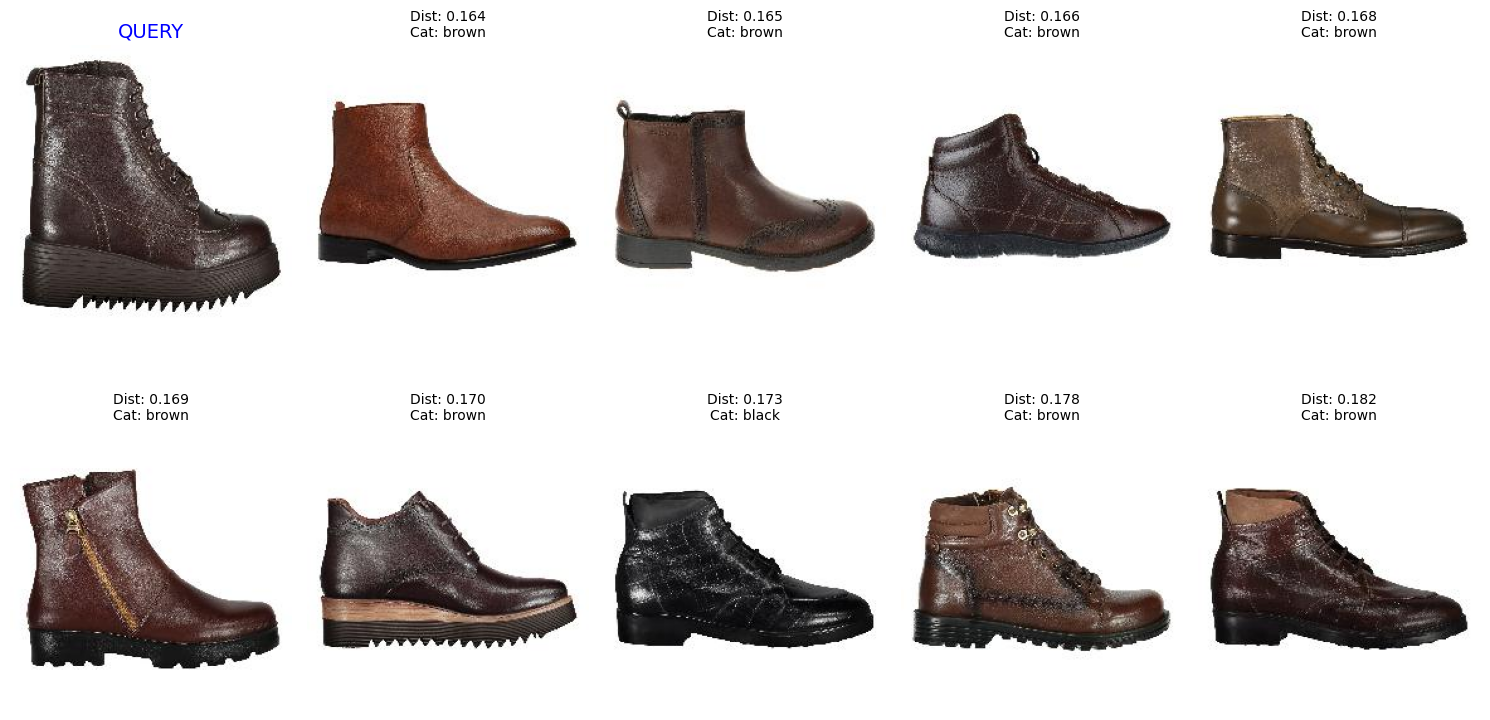

In [12]:
# Choose a random image
test_index = np.random.randint(0, len(df_processed))
query_path = df_processed.iloc[test_index]['image_path']
query_id = df_processed.iloc[test_index]['product_id']
query_category = df_processed.iloc[test_index]['color_category']

print(f"--- Query Image ---")
print(f"ID: {query_id} | Category: {query_category}")

recommendations_df = recommend_similar_products(query_path, feature_extractor_model, knn, df_processed)

print("\n--- Top 9 Recommendations in Table ---")
print(recommendations_df[['product_id', 'color_category', 'similarity_distance']])

plot_recommendations(query_path, recommendations_df, n_cols=5)